In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [3]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train'), sample_n=8000)
X_test, y_test = read_data(get_dataset('valid'), sample_n=2000)
# X_train, y_train = read_data(get_dataset('train'), sample_n=100)
# X_test, y_test = read_data(get_dataset('valid'), sample_n=100)

2018-12-04 15:27:25,611 [INFO] Reading data/train/sentiment_analysis_trainingset.csv.tokenized.csv..
2018-12-04 15:27:27,503 [INFO] Reading data/train/sentiment_analysis_trainingset.csv..
2018-12-04 15:27:29,226 [INFO] Take 8000 samples with random state 1
2018-12-04 15:27:29,257 [INFO] Reading data/valid/sentiment_analysis_validationset.csv.tokenized.csv..
2018-12-04 15:27:29,570 [INFO] Reading data/valid/sentiment_analysis_validationset.csv..
2018-12-04 15:27:29,860 [INFO] Take 2000 samples with random state 1


In [4]:
# del fm['tfidf_sv']
# del fm['tfidf_sv_dense']
# del fm['lsa_200_sv']
# del fm['lsa_500_sv']
# del fm['count_tiny']

In [5]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [6]:
from fgclassifier.features import FeaturePipeline, logger

def build_features(fm_names, fm):
    for name in fm_names:
        logger.info(f'Building features for {name}...')
        model = FeaturePipeline.from_spec(name, cache=fm)
        model.fit_transform(X_train)
        model.transform(X_test)
    
build_features(['count', 'count_sv', 'count_tiny'], fm)

C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2018-12-04 15:27:30,776 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-04 15:27:30,791 [INFO] Building features for count...
2018-12-04 15:27:30,792 [INFO] Fit & Transform CountVectorizer...
2018-12-04 15:28:04,118 [INFO] Vocab Size: 6956
2018-12-04 15:28:05,870 [INFO] Building features for count_sv...
2018-12-04 15:28:05,871 [INFO] Fit & Transform CountVectorizer...
2018-12-04 15:28:38,691 [INFO] Vocab Size: 3372
2018-12-04 15:28:40,404 [INFO] Building features for count_tiny...
2018-12-04 15:28:40,405 [INFO] Fit & Transform CountVectorizer...
2018-12-04 15:29:11,507 [INFO] Vocab Size: 1037


Exam the quality of the top terms:

In [7]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count', 'count_sv', 'count_tiny']:
    model = fm[mn]['model'].named_steps[mn]
    key = next(filter(lambda x: 'fit_transform' in x, fm[mn].keys()))
    x_train = fm[mn][key]
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.3f, max_df: %.3f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:5]]))

Data Shape: (8000,) (2000,)

min_df: 0.005, max_df: 0.990, ngram_range: (1, 5)

vocab size: 6956

， 	 174613
是 	 25167
很 	 21926
吃 	 18487
也 	 16800

min_df: 0.010, max_df: 0.990, ngram_range: (1, 5)

vocab size: 3372

， 	 174613
是 	 25167
很 	 21926
吃 	 18487
也 	 16800

min_df: 0.030, max_df: 0.600, ngram_range: (1, 5)

vocab size: 1037

！ 	 14847
我 	 11366
和 	 8712
感觉 	 6914
可以 	 6770


Save the word count features, as it is pretty slow to run for the whole dataset...

In [8]:
from sklearn.externals import joblib


def partial_get(d, keyword):
    key = next(filter(lambda x: x.startswith(keyword), d.keys()))
    return d[key]

def save_transform_cache(mn, path=None):
    path = path or f'data/fm_cache-{mn}'
    Xtrain = partial_get(fm[mn], 'fit_transform')
    Xtest = partial_get(fm[mn], 'transform')
    joblib.dump(Xtrain, path + '-train.pkl')
    joblib.dump(Xtest, path + '-test.pkl')
    print(f'Saved {path}')
    
save_transform_cache('count')
save_transform_cache('count_sv')
save_transform_cache('count_tiny')
joblib.load('data/fm_cache-count-test.pkl')

Saved data/fm_cache-count
Saved data/fm_cache-count_sv
Saved data/fm_cache-count_tiny


<2000x6956 sparse matrix of type '<class 'numpy.int64'>'
	with 320489 stored elements in Compressed Sparse Row format>

Build more features

In [9]:
build_features(['tfidf', 'tfidf_dense', 'lsa_500', 'lsa_1k'], fm)
build_features(['tfidf_sv', 'tfidf_sv_dense', 'lsa_500_sv'], fm)
build_features(['tfidf_tiny', 'tfidf_tiny_dense', 'lsa_500_tiny'], fm)
build_features(['word2vec'], fm)
build_features(['hashing'], fm)

2018-12-04 15:29:13,840 [INFO] Building features for tfidf...
2018-12-04 15:29:13,841 [INFO]   count: fit_transform use cache.
2018-12-04 15:29:13,842 [INFO] Fit & Transform TF-IDF...
2018-12-04 15:29:13,964 [INFO]   count: transform use cache.
2018-12-04 15:29:13,976 [INFO] Building features for tfidf_dense...
2018-12-04 15:29:13,977 [INFO]   tfidf: fit_transform use cache.
2018-12-04 15:29:14,168 [INFO]   tfidf: transform use cache.
2018-12-04 15:29:14,217 [INFO] Building features for lsa_500...
2018-12-04 15:29:14,219 [INFO]   tfidf: fit_transform use cache.
2018-12-04 15:29:14,221 [INFO] Fit & Transform TruncatedSVD...
2018-12-04 15:29:22,994 [INFO]   tfidf: transform use cache.
2018-12-04 15:29:23,166 [INFO] Building features for lsa_1k...
2018-12-04 15:29:23,168 [INFO]   tfidf: fit_transform use cache.
2018-12-04 15:29:23,171 [INFO] Fit & Transform TruncatedSVD...
2018-12-04 15:29:41,083 [INFO]   tfidf: transform use cache.
2018-12-04 15:29:41,322 [INFO] Building features for tfi

2018-12-04 15:30:11,322 [INFO] EPOCH 8 - PROGRESS: at 82.50% examples, 597044 words/s, in_qsize 6, out_qsize 0
2018-12-04 15:30:11,698 [INFO] worker thread finished; awaiting finish of 2 more threads
2018-12-04 15:30:11,712 [INFO] worker thread finished; awaiting finish of 1 more threads
2018-12-04 15:30:11,718 [INFO] worker thread finished; awaiting finish of 0 more threads
2018-12-04 15:30:11,719 [INFO] EPOCH - 8 : training on 1516568 raw words (1448799 effective words) took 2.4s, 602952 effective words/s
2018-12-04 15:30:12,750 [INFO] EPOCH 9 - PROGRESS: at 42.49% examples, 597787 words/s, in_qsize 6, out_qsize 0
2018-12-04 15:30:13,757 [INFO] EPOCH 9 - PROGRESS: at 85.12% examples, 607462 words/s, in_qsize 5, out_qsize 0
2018-12-04 15:30:14,080 [INFO] worker thread finished; awaiting finish of 2 more threads
2018-12-04 15:30:14,082 [INFO] worker thread finished; awaiting finish of 1 more threads
2018-12-04 15:30:14,093 [INFO] worker thread finished; awaiting finish of 0 more thread

In [10]:
save_transform_cache('tfidf')
save_transform_cache('tfidf_sv')
save_transform_cache('tfidf_tiny')
save_transform_cache('lsa_1k')
save_transform_cache('lsa_500_sv')
save_transform_cache('lsa_500_tiny')
save_transform_cache('word2vec')
save_transform_cache('hashing')

Saved data/fm_cache-tfidf
Saved data/fm_cache-tfidf_sv
Saved data/fm_cache-tfidf_tiny
Saved data/fm_cache-lsa_1k
Saved data/fm_cache-lsa_500_sv
Saved data/fm_cache-lsa_500_tiny
Saved data/fm_cache-word2vec
Saved data/fm_cache-hashing


## The Very Basic TF-IDF + LDA classifier

In [11]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.train import fm_cross_check

Check a basic model

In [12]:
model = Baseline('SGD_Logistic', fm=fm['lsa_500']['model'])
# Always pass in the original features
# the pipeline will take care of the cache
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 15:30:37,289 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 15:30:46,986 [INFO]   lsa_500: transform use cache.
2018-12-04 15:30:47,059 [INFO] [Validate]: F1 Scores
2018-12-04 15:30:47,061 [INFO]   location_traffic_convenience            	0.4247
2018-12-04 15:30:47,063 [INFO]   location_distance_from_business_district	0.2745
2018-12-04 15:30:47,066 [INFO]   location_easy_to_find                   	0.4599
2018-12-04 15:30:47,069 [INFO]   service_wait_time                       	0.4081
2018-12-04 15:30:47,071 [INFO]   service_waiters_attitude                	0.5762
2018-12-04 15:30:47,074 [INFO]   service_parking_convenience             	0.3910
2018-12-04 15:30:47,076 [INFO]   service_serving_speed                   	0.4893
2018-12-04 15:30:47,079 [INFO]   price_level                             	0.4502
2018-12-04 15:30:47,082 [INFO]   price_cost_effective                    	0.3343
2018-12-04 15:30:47,084 [INFO]   price_discount                          	0.5420
2018-12

lsa_500_SGD_Logistic final score: 0.441367193763596


Logistic is much slower but performs not much better than Stochastic logistic.

In [13]:
model = Baseline('SGD_Huber', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 15:30:47,302 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 15:30:55,224 [INFO]   lsa_500: transform use cache.
2018-12-04 15:30:55,282 [INFO] [Validate]: F1 Scores
2018-12-04 15:30:55,285 [INFO]   location_traffic_convenience            	0.4090
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 15:30:55,289 [INFO]   location_distance_from_business_district	0.3610
2018-12-04 15:30:55,292 [INFO]   location_easy_to_find                   	0.4167
2018-12-04 15:30:55,295 [INFO]   service_wait_time                       	0.4146
2018-12-04 15:30:55,299 [INFO]   service_waiters_attitude                	0.5344
2018-12-04 15:30:55,301 [INFO]   service_parking_convenience             	0.3625
2018-12-04 15:30:55,304 [INFO]   service_serving_speed                   	0.4501
2018-1

lsa_500_SGD_Huber final score: 0.4194666499484197


In [14]:
model = Baseline('SGD_SVC', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 15:30:55,527 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 15:31:03,224 [INFO]   lsa_500: transform use cache.
2018-12-04 15:31:03,291 [INFO] [Validate]: F1 Scores
2018-12-04 15:31:03,294 [INFO]   location_traffic_convenience            	0.4220
2018-12-04 15:31:03,296 [INFO]   location_distance_from_business_district	0.3418
2018-12-04 15:31:03,300 [INFO]   location_easy_to_find                   	0.4758
2018-12-04 15:31:03,302 [INFO]   service_wait_time                       	0.3165
2018-12-04 15:31:03,304 [INFO]   service_waiters_attitude                	0.4894
2018-12-04 15:31:03,306 [INFO]   service_parking_convenience             	0.2997
2018-12-04 15:31:03,308 [INFO]   service_serving_speed                   	0.4586
2018-12-04 15:31:03,311 [INFO]   price_level                             	0.4751
2018-12-04 15:31:03,313 [INFO]   price_cost_effective                    	0.4028
2018-12-04 15:31:03,315 [INFO]   price_discount                          	0.5457
2018-12

lsa_500_SGD_SVC final score: 0.4257940975265776


In [15]:
model = Baseline('Ridge', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 15:31:03,532 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 15:31:24,633 [INFO]   lsa_500: transform use cache.
2018-12-04 15:31:24,705 [INFO] [Validate]: F1 Scores
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 15:31:24,708 [INFO]   location_traffic_convenience            	0.4041
2018-12-04 15:31:24,712 [INFO]   location_distance_from_business_district	0.2906
2018-12-04 15:31:24,715 [INFO]   location_easy_to_find                   	0.3729
2018-12-04 15:31:24,717 [INFO]   service_wait_time                       	0.3011
2018-12-04 15:31:24,720 [INFO]   service_waiters_attitude                	0.5173
2018-12-04 15:31:24,722 [INFO]   service_parking_convenience             	0.2550
2018-12-04 15:31:24,724 [INFO]   service_serving_speed                   	0.3427
2018-1

lsa_500_Ridge final score: 0.3650830064680127


## Search for the Best Feature + Classifier Combination

In [16]:
# Run for all classifiers and feature builders
train_avg_scores, train_scores = defaultdict(dict), defaultdict(dict)
test_avg_scores, test_scores = defaultdict(dict), defaultdict(dict)
test_time, train_time = defaultdict(dict), defaultdict(dict)

In [17]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [18]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'test': test_scores,
        'test_time': test_time,
        'test_avg': test_avg_scores,
        'train': train_scores,
        'train_time': train_time,
        'train_avg': train_avg_scores
    }
}

In [39]:
from IPython.display import clear_output

# We'd only need to run the dummy models on one feature model,
# as they do not care about the features
# fm_cross_check(
#     ['tfidf_sv'],
#     ['DummyStratified', 'DummyMostFrequent'],
#     model_cls=Dummy, **conf)

# Naive Bayes models cannot handle negative values, so we pass
# in only tfidf features
# fm_cross_check(
#     ['count', 'count_sv', 'count_tiny',
#      'tfidf', 'tfidf_sv', 'tfidf_tiny'],
#     ['ComplementNB'], **conf)

# Only SGD methods can handle sparse matrix
# fm_cross_check(
#     [
#      'lsa_500',
#      'lsa_500_sv',
#      'lsa_500_tiny',
#      'lsa_1k',
#      'word2vec',
#      'count',
#      'count_sv',
#      'count_tiny',
#      'tfidf'
#      'tfidf_sv',
#      'tfidf_tiny',
#      'hashing',
#     ],
#     ['SGD_Logistic', 'SGD_SVC'], **conf)
# clear_output()

# # All other models can run on many classifiers
# results = fm_cross_check(
#     ['lsa_500',
#      'lsa_500_sv',
#      'lsa_500_tiny',
#      'lsa_1k',
#      'word2vec',
#     ],
#     ['LDA', 'QDA', 'Ridge'], **conf)
# clear_output()

# results = fm_cross_check(
#     [# 'tfidf_sv_dense',
#      'tfidf_tiny_dense'],
#     ['LDA', 'QDA', 'Ridge'], **conf)
# clear_output()

In [76]:
# Boosting is too damn slow...
# results = fm_cross_check(
#     ['lsa_500',
#      'lsa_500_sv',
#      'lsa_500_tiny',
#      'lsa_1k',
#      'word2vec',
#     ],
#     ['XGB', 'AdaBoost', 'GradientBoost'], **conf)
# clear_output()

In [77]:
def extract_scores(scores, avg_scores):
    rows = {}
    for fm_name in scores:
        for clf_name in avg_scores[fm_name]:
            key = f'{fm_name}.{clf_name}'
            rows[key] = [avg_scores[fm_name][clf_name], *scores[fm_name][clf_name]]
    df = pd.DataFrame(rows)
    df.index = ['average', *y_train.columns]
    return df.T.sort_values('average', ascending=False)

df_train = extract_scores(train_scores, train_avg_scores)
df_test = extract_scores(test_scores, test_avg_scores)
df_test

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
tfidf.SGD_SVC,0.489795,0.454481,0.332446,0.491820,0.437609,0.601185,0.460738,0.498250,0.541640,0.461819,...,0.479864,0.527874,0.505368,0.499980,0.492363,0.534240,0.403551,0.522764,0.489177,0.511281
tfidf_sv.SGD_SVC,0.485976,0.484695,0.349542,0.488639,0.463949,0.582835,0.444061,0.513078,0.518620,0.482393,...,0.483864,0.548889,0.504037,0.512662,0.465865,0.520124,0.384468,0.456907,0.472649,0.496588
tfidf_sv.SGD_Logistic,0.481816,0.441332,0.332622,0.486173,0.431565,0.603176,0.399866,0.515237,0.534877,0.444846,...,0.492842,0.526994,0.484130,0.499887,0.486215,0.563688,0.406090,0.442718,0.509418,0.509445
lsa_1k.LDA,0.480478,0.417291,0.339043,0.495739,0.450342,0.587103,0.477025,0.500050,0.518758,0.464979,...,0.448284,0.492853,0.474880,0.474272,0.458206,0.548583,0.401796,0.502803,0.512260,0.514168
tfidf.SGD_Logistic,0.474229,0.412907,0.313088,0.441457,0.407049,0.589092,0.416668,0.474110,0.530431,0.473495,...,0.489823,0.524729,0.482002,0.479120,0.477235,0.556494,0.403010,0.459272,0.498853,0.508996
tfidf_tiny_dense.LDA,0.468857,0.476830,0.334322,0.521752,0.468711,0.576390,0.474247,0.471370,0.480514,0.489135,...,0.452438,0.459793,0.470952,0.463497,0.463351,0.480427,0.355560,0.409849,0.481175,0.506026
lsa_500.LDA,0.464987,0.431697,0.331870,0.484233,0.433379,0.584557,0.394787,0.470415,0.494115,0.444043,...,0.486805,0.482176,0.463426,0.462501,0.452025,0.527255,0.384982,0.462963,0.490531,0.479240
tfidf_tiny.SGD_Logistic,0.463661,0.434263,0.335465,0.499371,0.411131,0.589900,0.439388,0.464687,0.497679,0.423394,...,0.473929,0.461286,0.474509,0.484046,0.476720,0.519083,0.364888,0.395902,0.470996,0.519753
tfidf_tiny.SGD_SVC,0.462867,0.465652,0.338041,0.505843,0.421339,0.593026,0.446320,0.462928,0.493627,0.451105,...,0.455579,0.456619,0.457755,0.469622,0.475524,0.502683,0.369668,0.402893,0.449972,0.493351
lsa_500_sv.LDA,0.460318,0.432554,0.329587,0.496804,0.452181,0.590158,0.371347,0.481463,0.486450,0.430205,...,0.474288,0.461873,0.442957,0.476594,0.453123,0.531066,0.363569,0.417685,0.488381,0.487020


In [78]:
# Save the results
results = conf['results'].copy()
del results['models']  # don't save models (which are huuuuge)
joblib.dump(results, 'data/model-selection-zh.pkl')

['data/model-selection-zh.pkl']

In [79]:
# important columns
imp_cols = ['count', 'count_sv', 'hashing', 'tfidf', 'tfidf_sv', 'lsa_1k', 'lsa_500', 'lsa_500_sv']

def extract_avg_scores(scores):
    df = pd.DataFrame(scores)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=False)
    df = df.sort_values(by='avg', ascending=False)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]

df_train_avg = extract_avg_scores(train_avg_scores)
df_test_avg = extract_avg_scores(test_avg_scores)
df_test_avg

,count,count_sv,hashing,tfidf,tfidf_sv,lsa_1k,lsa_500,lsa_500_sv
LDA,NaN,NaN,NaN,NaN,NaN,0.480478,0.464987,0.460318
SGD_SVC,0.390142,0.425923,0.427050,0.489795,0.485976,0.454525,0.439844,0.447014
SGD_Logistic,0.398194,0.415961,0.408354,0.474229,0.481816,0.459940,0.429479,0.434596
ComplementNB,0.418266,0.408352,NaN,0.415771,0.420211,NaN,NaN,NaN
Ridge,NaN,NaN,NaN,NaN,NaN,0.378423,0.365083,0.365766
AdaBoost,NaN,NaN,NaN,NaN,NaN,NaN,0.314162,NaN
GradientBoost,NaN,NaN,NaN,NaN,NaN,NaN,0.305216,0.309314
XGB,NaN,NaN,NaN,NaN,NaN,NaN,0.295442,NaN
QDA,NaN,NaN,NaN,NaN,NaN,0.303178,0.328704,0.323939
DummyStratified,NaN,NaN,NaN,NaN,0.247550,NaN,NaN,NaN


In [80]:
def extract_running_time(times):
    df = pd.DataFrame(times)
    df = df.sort_index(axis=1)
    return df[imp_cols]
    
df_train_time = extract_running_time(train_time)
df_test_time = extract_running_time(test_time)
df_train_time

,count,count_sv,hashing,tfidf,tfidf_sv,lsa_1k,lsa_500,lsa_500_sv
AdaBoost,NaN,NaN,NaN,NaN,NaN,NaN,880.807359,NaN
ComplementNB,0.621998,0.676001,NaN,0.604992,0.501993,NaN,NaN,NaN
DummyMostFrequent,NaN,NaN,NaN,NaN,0.132000,NaN,NaN,NaN
DummyStratified,NaN,NaN,NaN,NaN,0.143001,NaN,NaN,NaN
GradientBoost,NaN,NaN,NaN,NaN,NaN,NaN,2823.637272,2722.850276
LDA,NaN,NaN,NaN,NaN,NaN,42.684195,17.286996,19.445996
QDA,NaN,NaN,NaN,NaN,NaN,111.998615,43.962909,44.442684
Ridge,NaN,NaN,NaN,NaN,NaN,50.170047,22.717876,22.517972
SGD_Logistic,7.507003,5.889997,14.397994,6.198000,4.672004,18.418051,11.211411,11.299011
SGD_SVC,5.287016,5.127646,12.601989,5.592995,3.863885,13.194000,8.348989,8.991003


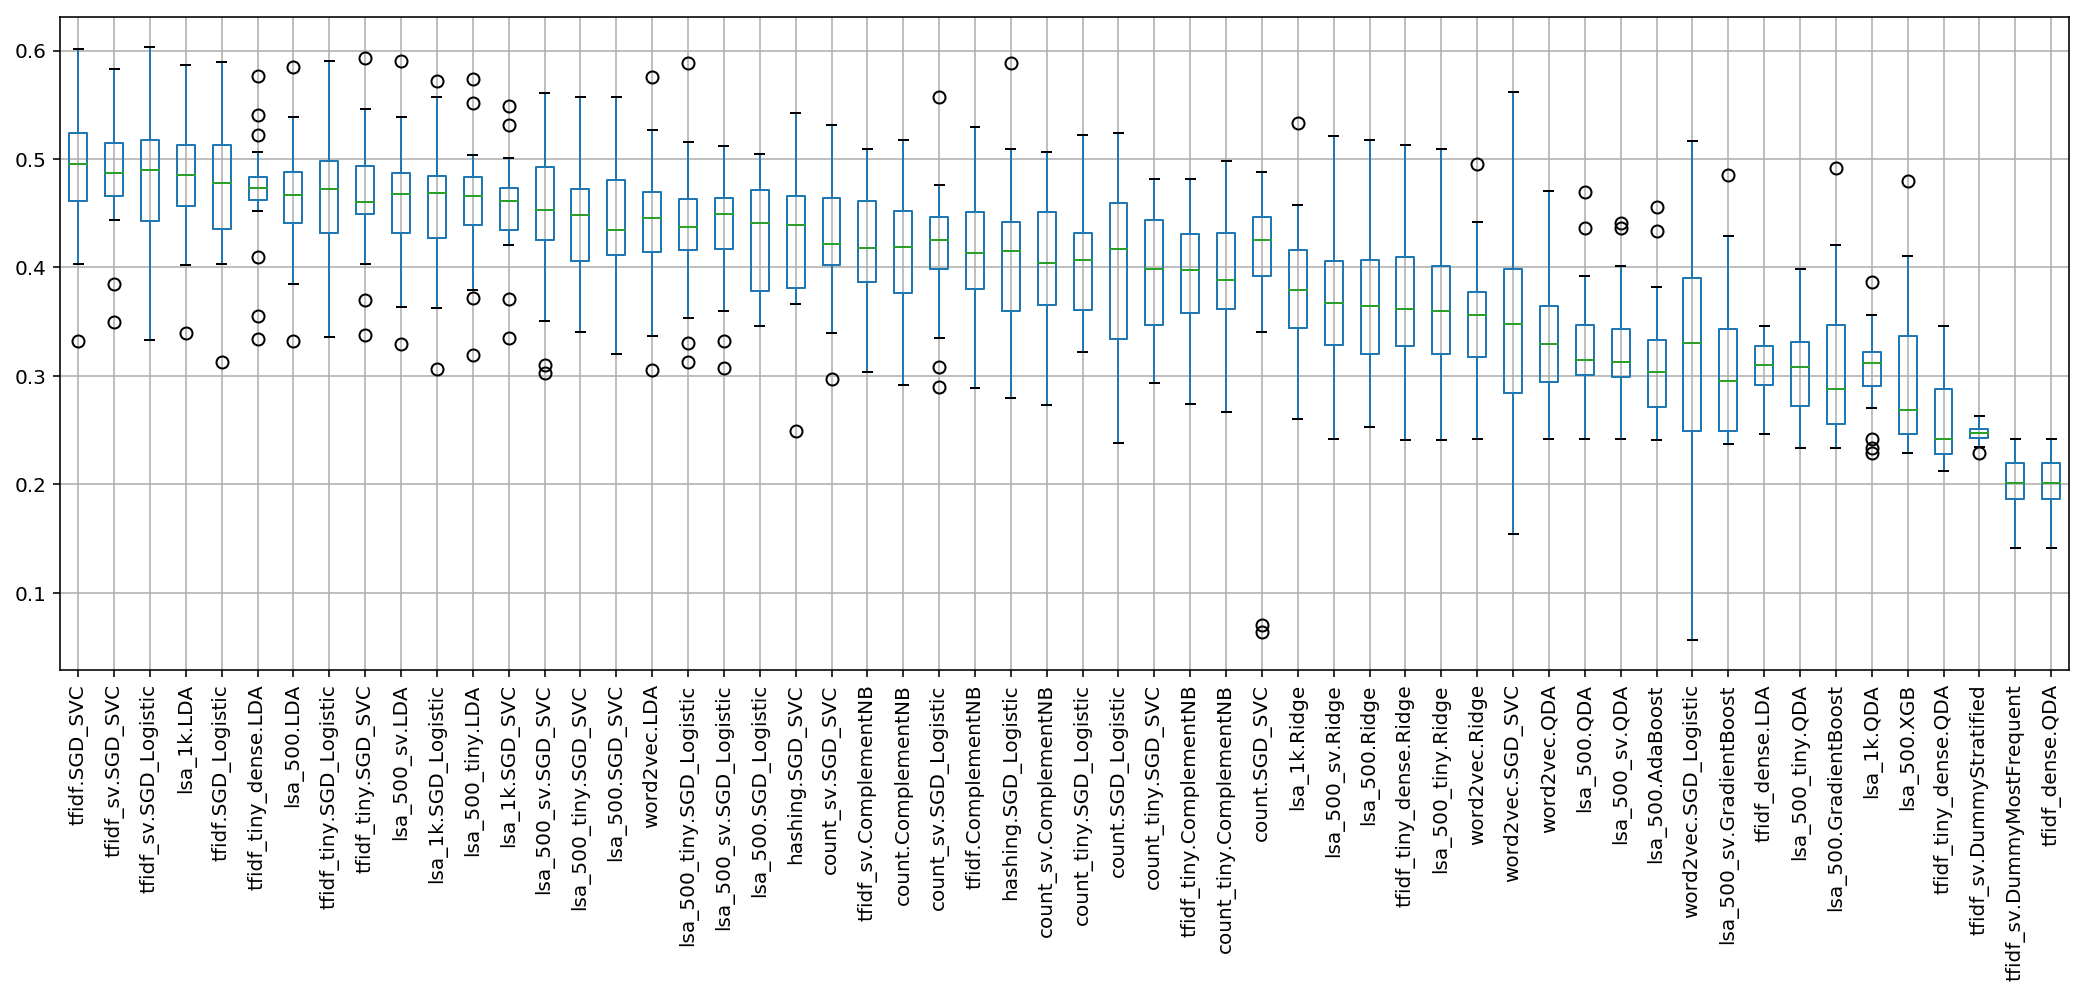

In [81]:
import matplotlib.pyplot as plt

df_test.T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [83]:
results = conf['results']

In [86]:
from fgclassifier.utils import save_model

# def clear_cache(model):
#     if hasattr(model, 'steps'):
#         for (name, step) in model.steps:
#             clear_cache(step)
#     if hasattr(model, 'cache'):
#         model.cache = None
#     return model

# for name, model in results['models'].items():
#     clear_cache(model)
#     save_model(model)

clear_output()

In [89]:
results['models']['lsa_500_sv_SGD_SVC']

Baseline(cache=None, classifier=None, fm=None, spec=None,
     steps=[('lsa_500_sv', FeaturePipeline(steps=lsa_500_sv)), ('SGD_SVC', MultiOutputClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge'... tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None))])

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [ ]:
# model = results['models']['lsa_500_en_LDA']
# print(X_test[0:1].shape)
# probas = model.predict_proba(X_test[0:1])
# probas[0].shape

In [ ]:
# model.predict(X_test[0:1])